# Lightweight Fine-Tuning Project

TODO: In this cell, describe your choices for each of the following

* PEFT technique:
* Model:
* Evaluation approach:
* Fine-tuning dataset:

The PEFT technique used is Lora. With the base configuration, Lora is applied at each layer of the model as can be seen here:

```
GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Linear(
      in_features=768, out_features=2304, bias=True
      (lora_dropout): ModuleDict(
        (default): Identity()
      )
      (lora_A): ModuleDict(
        (default): Linear(in_features=768, out_features=8, bias=False)
      )
      (lora_B): ModuleDict(
        (default): Linear(in_features=8, out_features=2304, bias=False)
      )
      (lora_embedding_A): ParameterDict()
      (lora_embedding_B): ParameterDict()
    )
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
```

This can be viewed using the command:

```
lora_model.base_model.model.transformer.h[0]
```

This notebook compares the base GPT2 model on a sentiment classification task for the 
IMDB movie reviews dataset.

Evaluation is performed using loss. This is a single label classification problem, and therefore a Binary Cross Entropy loss is used. This can be validated using:

```
lora_model.config

GPT2Config {
  ...
  "problem_type": "single_label_classification",
  ...
}
```

The code validates the loss function here:

https://github.com/huggingface/transformers/blob/08a194fcd615dcf9406a7e319d637cc303097f46/src/transformers/models/gpt2/modeling_gpt2.py#L1714

```
elif self.config.problem_type == "single_label_classification":
  loss_fct = CrossEntropyLoss()
  loss = loss_fct(pooled_logits.view(-1, self.num_labels), labels.view(-1))
```

The IMDB movie review dataset contains 25000 training and 25000 evaluation (test) samples. In order to reduce training and evaluation time, a sample of 2000 training and 500 test samples are taken at random. 

## Setup

* Install these 2 Python libraries if required

In [1]:
! pip install -q "datasets==2.15.0"
! pip install accelerate -U
! pip install scikit-learn

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.3 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 35.4 MB/s eta 0:00:00


* Check datasets version

In [2]:
import datasets
datasets.__version__

'2.15.0'

## Imports

In [3]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset
from peft import get_peft_model, PeftModelForSequenceClassification, LoraConfig

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

## Results

In [4]:
results = {}

## Utility Functions

In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    num_train_epochs=1,
    weight_decay=0.01,
)

peft_training_args = TrainingArguments(
    output_dir="./peft_results",
    evaluation_strategy='steps',  # Change to 'steps' to evaluate more frequently
    eval_steps=500,  # Evaluate every 500 steps
    save_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=1, # Train batch sizes > 1 lead to intermittent out of memory errors
    num_train_epochs=1,
    weight_decay=0.01,
)

In [6]:
def setup_tokenizer(tokenizer_name="openai-community/gpt2"):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_name)
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

def tokenize_dataset(tokenizer, dataset, return_tensors=None):
    def _tokenize(tokenizer, dataset, return_tensors):
        tokenized_dataset = dataset.map(
                lambda x: tokenizer(
                    x['text'], 
                    padding="max_length", 
                    truncation=True,
                    return_tensors=return_tensors)
        )
        return tokenized_dataset

    tokenized_ds = {}

    tokenized_ds['train'] = _tokenize(tokenizer, dataset['train'], return_tensors=return_tensors)
    tokenized_ds['test'] = _tokenize(tokenizer, dataset['test'], return_tensors=return_tensors)
    
    return tokenized_ds

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [8]:
def load_gpt2_for_sequence_classification(tokenizer, requires_grad=False):
    """
    Load GPT2 model for sequence classification
    """
    model = GPT2ForSequenceClassification.from_pretrained(
        "gpt2",
        num_labels=2,
        id2label={0: "NEGATIVE", 1: "POSITIVE"},
        label2id={"NEGATIVE": 0, "POSITIVE": 1},
    )
    
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Freeze all the parameters of the base model
    for param in model.base_model.parameters():
        param.requires_grad = requires_grad
        
    return model

## Loading and Evaluating a Foundation Model

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

* Load dataset

In [9]:
dataset = load_dataset("stanfordnlp/imdb")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

* Load tokenizer and pre-process datasets

In [10]:
tokenizer = setup_tokenizer("openai-community/gpt2")
tokenized_ds = tokenize_dataset(tokenizer, dataset)

print(tokenized_ds)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 25000
}), 'test': Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 25000
})}


In [11]:
train_dataset = tokenized_ds['train'].shuffle(seed=42).select(range(2000))
test_dataset = tokenized_ds['test'].shuffle(seed=42).select(range(500))

* Create a classifier head for GPT2

In [12]:
model = load_gpt2_for_sequence_classification(tokenizer)
print(model)  # Note that the final layer of GPT2 is called score not classifier

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)


* Feed test dataset into the model to get predictions

Note that this is with untrained classifier head

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

/home/student/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


* Predict based on a random sample

In [24]:
sample_id = 231
print(f"The ground truth sentiment is {'Positive' if test_dataset[0]['label'] == 1 else 'Negative'}")
input_ids = tokenizer.encode(test_dataset[0]['text'], return_tensors="pt")
input_ids = input_ids.to(model.device)

# getting the logits
logits = model(input_ids).logits

# getting the predicted class
predicted_class = logits.argmax(-1).item()

print(f"The sentiment predicted by the model is: {'Positive' if predicted_class == 1 else 'Negative'}")

The ground truth sentiment is Positive
The sentiment predicted by the model is: Negative


In [25]:
eval_results = trainer.evaluate()
results['base_model_eval_acc'] = eval_results['eval_accuracy']
print(eval_results)

{'eval_loss': 0.813205897808075, 'eval_accuracy': 0.52, 'eval_runtime': 44.9618, 'eval_samples_per_second': 11.121, 'eval_steps_per_second': 1.401}


In [26]:
eval_results

{'eval_loss': 0.813205897808075,
 'eval_accuracy': 0.52,
 'eval_runtime': 44.9618,
 'eval_samples_per_second': 11.121,
 'eval_steps_per_second': 1.401}

On an untrained model, the `eval_accuracy` varies as the output weights will be randomly initialised in the untrained model. In experiments, an example accuracy is 0.5

## Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.

* Basic LoraConfig initially

Not setting task_type correctly leads to issues, such as an error "input_ids must be specified"

In [27]:
config = LoraConfig(
    task_type="SEQ_CLS", 
    inference_mode=False, # For now we are training... 
#     r=8, 
#     lora_alpha=16, 
#     lora_dropout=0.1
)

* Load GPT2 model for Sequence Classification and set up PEFT on Lora Model

In [28]:
model = load_gpt2_for_sequence_classification(tokenizer)

lora_model = get_peft_model(model, config)
lora_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/peft/tuners/lora.py:475: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 297,984 || all params: 124,737,792 || trainable%: 0.23888830740245906


* Training config

Note that training batch sizes > 1 intermittently fail with out of memory errors

In [29]:
trainer = Trainer(
    model=lora_model,
    args=peft_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

/home/student/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [30]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.844600,1.021238,0.508000
1000,0.962400,0.821164,0.518000
1500,0.777200,0.835721,0.520000
2000,0.795800,0.813206,0.520000


Checkpoint destination directory ./peft_results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./peft_results/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


AttributeError: 'TrainOutput' object has no attribute 'training_accuracy'

* Can't determine train accuracy from Trainer, even though it appears in the output. 

The following is a typical output from Trainer:

```
TrainOutput(global_step=2000, training_loss=0.8449949798583984, metrics={'train_runtime': 621.5276, 'train_samples_per_second': 3.218, 'train_steps_per_second': 3.218, 'total_flos': 1048829755392000.0, 'train_loss': 0.8449949798583984, 'epoch': 1.0})
```


In [38]:
print(train_results)

TrainOutput(global_step=2000, training_loss=0.8449949798583984, metrics={'train_runtime': 621.5276, 'train_samples_per_second': 3.218, 'train_steps_per_second': 3.218, 'total_flos': 1048829755392000.0, 'train_loss': 0.8449949798583984, 'epoch': 1.0})


In [ ]:
# results['lora_model_train_acc'] = train_results.training_accuracy

* Save weights

In [32]:
lora_model.save_pretrained("gpt2-lora-imdb")

## Performing Inference with a PEFT Model

TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

In [33]:
model = load_gpt2_for_sequence_classification(tokenizer)
lora_model = PeftModelForSequenceClassification.from_pretrained(model, "gpt2-lora-imdb")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
trainer = Trainer(
    model=lora_model,
    args=peft_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

/home/student/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [35]:
eval_results = trainer.evaluate()
results['lora_model_eval_acc'] = eval_results['eval_accuracy']
print(eval_results)

{'eval_loss': 0.813205897808075, 'eval_accuracy': 0.52, 'eval_runtime': 45.1651, 'eval_samples_per_second': 11.07, 'eval_steps_per_second': 1.395}


## Chart results

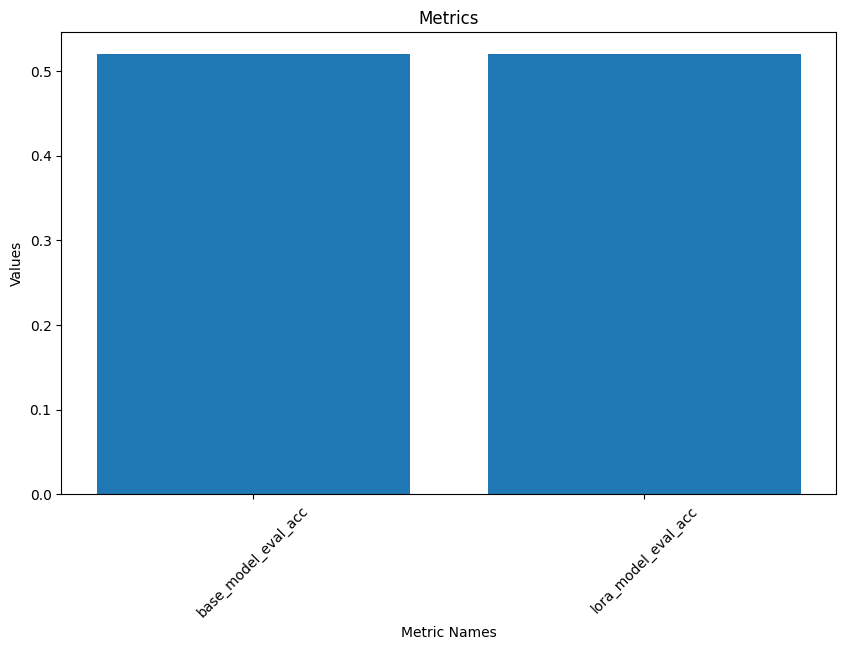

In [36]:
categories = list(results.keys())
values = list(results.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, values) 

plt.title('Metrics')
plt.xlabel('Metric Names')
plt.ylabel('Values')
plt.xticks(rotation=45)  

plt.show()

It can be seen from this graph that Lora starts to improve the evaluation accuracy of the model (from circa 5.08 to 5.2) with a limited dataset and single epoch of training.